In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [3]:
# Hyper-paramters
matches_threshold = 0.75

In [4]:
def plotGrayscaleImage(image):
    h,w = image.shape[:2]
    plt.imshow(image, cmap='gray')
    
def plotColorImage(image):
    b,g,r = cv2.split(image)
    image = cv2.merge([r,g,b])
    plt.imshow(image)

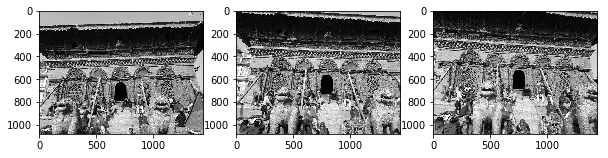

In [5]:
img1 = cv2.imread('images/1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('images/2.jpg', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('images/3.jpg', cv2.IMREAD_GRAYSCALE)

figure = plt.figure(figsize=(10.0, 3.0))
plt.subplot(131)
plotGrayscaleImage(img1)

plt.subplot(132)
plotGrayscaleImage(img2)

plt.subplot(133)
plotGrayscaleImage((img3))

plt.show()

In [6]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

In [7]:
# find the keypoints and descriptors with SIFT
keypoint1, descriptor1 = sift.detectAndCompute(img1, None)
keypoint2, descriptor2 = sift.detectAndCompute(img2, None)
keypoint3, descriptor3 = sift.detectAndCompute(img3, None)

print("# keypoints: {}, descriptors: {} of image 1".format(len(keypoint1), descriptor1.shape))

# keypoints: 16611, descriptors: (16611, 128) of image 1


In [8]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches12 = bf.knnMatch(descriptor1, descriptor2, k=2)
matches23 = bf.knnMatch(descriptor2, descriptor3, k=2)
matches31 = bf.knnMatch(descriptor3, descriptor1, k=2)

In [9]:
# Apply ratio test
def bestMatches(matches, threshold):
    bestmatches = []
    bestmatchesListOfList = []
    for m,n in matches:
        if m.distance > threshold * n.distance:
            bestmatches.append(m)
            bestmatchesListOfList.append([m])
    return bestmatches, bestmatchesListOfList

In [10]:
bestmatches12, bestmatchesList12 = bestMatches(matches12, matches_threshold)
bestmatches23, bestmatchesList23 = bestMatches(matches23, matches_threshold)
bestmatches31, bestmatchesList31 = bestMatches(matches31, matches_threshold)

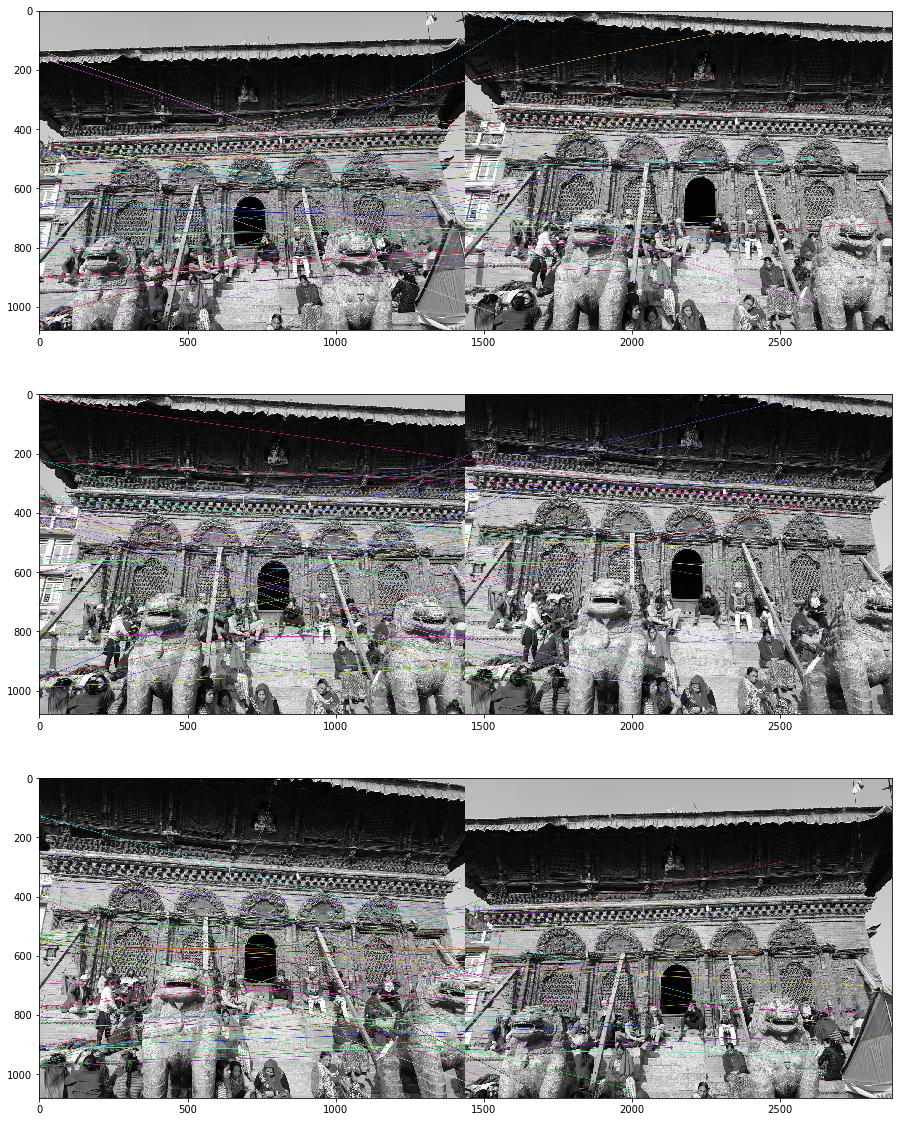

In [11]:
# cv2.drawMatchesKnn expects list of lists as matches while drawMatches dont required list
# eg:
# img12 = cv2.drawMatches(img1,keypoint1, img2,keypoint2, bestmatches12,None,flags=2)
# img12 = cv2.drawMatchesKnn(img1,keypoint1, img2,keypoint2, bestmatchesList12,None,flags=2)

img12 = cv2.drawMatchesKnn(img1,keypoint1, img2,keypoint2, bestmatchesList12[:50],None,flags=2)
img23 = cv2.drawMatchesKnn(img2,keypoint2, img3,keypoint3, bestmatchesList12[:50],None,flags=2)
img31 = cv2.drawMatchesKnn(img3,keypoint3, img1,keypoint1, bestmatchesList12[:50],None,flags=2)

figure = plt.figure(figsize=(20.0, 20.0))

plt.subplot(311)
plt.imshow(img12)

plt.subplot(312)
plt.imshow(img23)

plt.subplot(313)
plt.imshow(img31)

plt.show()

In [12]:
# Normalize points with K^{-1}
# (u v 1) = K^-1 * (u’ v’ 1)
# K is the calibration matrix in intrinsics.txt
# K = [1123.26 0      706.85]
#      0      1123.26 542.07]
#      0        0        1]

K = np.array([
    [1123.26, 0, 706.85],
    [0, 1123.26, 542.07],
    [0, 0, 1]
])

In [13]:
def to_homogenous(points):
    return np.concatenate((points, np.ones((points.shape[0], 1))), axis=1)

def normalize(points, K):
    return np.linalg.inv(K).dot(points.T).T

In [14]:
# make point homogenous i.e (u v 1)
points1 = np.float32([ keypoint1[m.queryIdx].pt for m in bestmatches12 ])
points2 = np.float32([ keypoint2[m.trainIdx].pt for m in bestmatches12 ])
    
homogenous_points1 = to_homogenous(points1)
homogenous_points2 = to_homogenous(points2)

# normalize homogenous points
# i.e. (u v 1) = K^-1 * (u' v' 1)
normalized_points1 = normalize(homogenous_points1, K)
normalized_points2 = normalize(homogenous_points2, K)

In [15]:
def get_linear_solution(points1, points2):
    points_number = points1.shape[0]
    A = np.zeros((points_number, 9))
    A[:,:3] = points1[:,0, np.newaxis] * points2
    A[:,3:6] = points1[:,1, np.newaxis] * points2
    A[:,6:] = points1[:,2, np.newaxis] * points2
    
    _, _, V = np.linalg.svd(A, full_matrices=True)
    
    M = V[-1,:].reshape((3,3))
    return M

In [16]:
def essential_matrix(normalized_points1, normalized_points2):
    '''
    function to calculate essential matrix for
    x from image1 and x' from image2
    '''
    E = get_linear_solution(normalized_points1, normalized_points2)
    u,s,v = np.linalg.svd(E)
    s = np.diag([(s[0] + s[1]) / 2., (s[0] + s[1]) / 2., 0.])
    E = u.dot(s.dot(v))
    return E

In [17]:
def get_distances_from_epipolar_lines(points1, points2, F):
    '''
    Get sum of distances from points of image1 to theirs 
    epipolar lines. Points should be in homogenous coordinates.
    '''
    epipolar_lines = F.dot(points2.T).T
    distances = np.abs(np.sum(points1 * epipolar_lines, axis=1)) / np.sqrt(epipolar_lines[:,0] ** 2 + epipolar_lines[:,1] ** 2)
    return distances

In [18]:
def ransac_essential_matrix(normalized_points1, normalized_points2, homogenous_points1, homogenous_points2, outliers_threshold, iterations, K):
    '''
    Compute essential matrix from image2 to image1 with RANSAC
    '''
    max_inliers = 0
    best_sample = np.empty(8, np.int)
    
    for _ in range(iterations):
        # select random 8 points
        sample = np.random.choice(normalized_points1.shape[0], 8, replace=False)
        
        # get the essential matrix
        E = essential_matrix(normalized_points1, normalized_points2)
        F = np.linalg.inv(K.T).dot(E.dot(np.linalg.inv(K)))
        distances = get_distances_from_epipolar_lines(homogenous_points1, homogenous_points2, F)
        
        if np.count_nonzero(distances < outliers_threshold) > max_inliers:
            best_sample = sample
            max_inliers = np.count_nonzero(distances < outliers_threshold)
            
    E = essential_matrix(normalized_points1[best_sample,:], normalized_points2[best_sample,:])
    F = np.linalg.inv(K.T).dot(E.dot(np.linalg.inv(K)))
    distances = get_distances_from_epipolar_lines(homogenous_points1, homogenous_points2, F)
    
    inliers1 = homogenous_points1[distances < outliers_threshold, :]
    inliers2 = homogenous_points2[distances < outliers_threshold, :]
    
    return E, F, distances, inliers1, inliers2, best_sample

In [19]:
# compute essential matrix with RANSAC
outliers_threshold = 5.
no_of_iterations = 10000
E12, F12, distances12, inliers1, inliers2, best_sample12 = ransac_essential_matrix(normalized_points1, normalized_points2, homogenous_points1, homogenous_points2, outliers_threshold, no_of_iterations, K)

In [20]:
def compute_3d_point(P1, P2, normalized_points1, normalized_points2):
    A = np.array([
        normalized_points1[0] * P1[2,:] - P1[0,:],
        normalized_points1[1] * P1[2,:] - P1[1,:],
        normalized_points2[0] * P2[2,:] - P2[0,:],
        normalized_points2[1] * P2[2,:] - P2[1,:]
    ])
    
    _,_,v = np.linalg.svd(A)
    return v[-1,:]

In [21]:
def number_of_good_points(P, points):
    camera_Z_direction = P.dot(np.array([0., 0., 100000., 1.]))[2]
    number_of_good_points = np.count_nonzero(P.dot(points.T).T[:,2] * camera_Z_direction > 0)
    
    return number_of_good_points

In [22]:
def compare_matrix(P1, P2, point1, point2):
    homogenous_points_3d = np.array([compute_3d_point(P1, P2, point1, point2) for point1, point2 in zip(point1, point2)])
    points_3d = homogenous_points_3d / homogenous_points_3d[:,-1,np.newaxis]
    
    return number_of_good_points(P1, points_3d) + number_of_good_points(P2, points_3d)


In [23]:
def get_projection_matrics_from_essential(E, points1, points2):
    '''
    Points should be normalized (i.e. multiplied by inverse of K)
    '''
    P1 = np.eye(3, M=4)
    u,s,vt = np.linalg.svd(E)
    u *= s[0]
    s /= s[0]
    w = np.array([
        [0., -1., 0.],
        [1.,  0., 0.],
        [0.,  0., 1.]
    ])
    u3 = u[:,2]
    P2s = [
        np.hstack((u.dot(w.dot(vt)), u3[:,np.newaxis])),
        np.hstack((u.dot(w.dot(vt)), -u3[:,np.newaxis])),
        np.hstack((u.dot(w.T.dot(vt)), u3[:,np.newaxis])),
        np.hstack((u.dot(w.T.dot(vt)), -u3[:,np.newaxis]))
    ]
    
    P2 = P2s[np.argmax([compare_matrix(P1, P, points1, points2) for P in P2s])]
    
    return P1, P2

In [24]:
# Get projection matrix
P2, P1 = get_projection_matrics_from_essential(E12, inliers2, inliers1)

In [25]:
def triangulate_points(P1, P2, points1, points2):
    ''' 
    Points should be normalized (multiplied by inverse of K) 
    '''
    hom_points_3d = np.array([compute_3d_point(P1, P2, point1, point2) for point1, point2 in zip(points1, points2)])
    points_3d = hom_points_3d / hom_points_3d[:,-1,np.newaxis]

    points = np.array(list(zip(points_3d[:,0].ravel(), points_3d[:,1].ravel(), points_3d[:,2].ravel())),dtype=[('x','f4'), ('y','f4'),('z', 'f4')])
    return hom_points_3d, points

In [26]:
# Traingulate the points
homogenous_points_3d, points3d = triangulate_points(P2, P1, normalized_points2, normalized_points1)

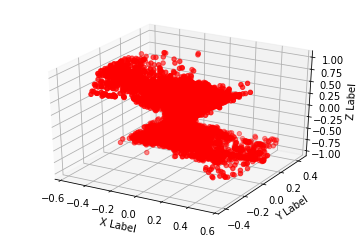

In [27]:
figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')
x,y,z = homogenous_points_3d[:,0], homogenous_points_3d[:,1], homogenous_points_3d[:,2]
ax.scatter(x, y, z, c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()